# Generalized Maxwell Model - Bayesian Workflow with Prior Safety

> **Handbook:** See [Generalized Maxwell Model](../../docs/source/models/gmm/index.rst) for model theory and [Tiered Prior Safety](../../docs/source/user_guide/03_advanced_topics/bayesian_inference.rst#prior-safety) for the convergence-based prior management system.

This notebook demonstrates the complete Bayesian inference workflow for the Generalized Maxwell Model (GMM), including NLSQ point estimation, warm-started NUTS sampling, and the tiered prior safety mechanism.

## Learning Objectives

After completing this notebook, you will be able to:
- Perform two-step Bayesian workflow: NLSQ → NUTS with warm-start
- Understand the tiered prior safety mechanism (hard failure, suspicious, good)
- Diagnose NLSQ convergence quality before Bayesian inference
- Analyze GMM posterior distributions with ArviZ
- Quantify parameter uncertainty and credible intervals
- Compare models with different numbers of modes (N=1 vs N=3)

## Prerequisites

- Understanding of Bayesian inference basics (recommended: `01-bayesian-basics.ipynb`)
- Familiarity with GMM fitting (recommended: `08-generalized_maxwell_fitting.ipynb`)
- Knowledge of MCMC diagnostics (R-hat, ESS, divergences)

**Estimated Time:** 30-45 minutes

In [1]:
# Google Colab Setup - Run this cell first!
# Skip if running locally with rheojax already installed

import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Install rheojax and dependencies
    !pip install -q rheojax
    
    # Colab uses float32 by default - we need float64 for numerical stability
    # This MUST be set before importing JAX
    import os
    os.environ['JAX_ENABLE_X64'] = 'true'
    
    print("✓ RheoJAX installed successfully!")
    print("✓ Float64 precision enabled")

## Setup and Imports

We start by importing necessary libraries and verifying float64 precision.

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
# MUST come before importing matplotlib
%matplotlib inline

# Standard scientific computing imports
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax

# RheoJAX imports - always explicit
from rheojax.models import GeneralizedMaxwell

# Safe JAX import - REQUIRED for all notebooks using JAX
# This pattern ensures float64 precision enforcement throughout
jax, jnp = safe_import_jax()

# Set reproducible random seed
np.random.seed(42)

# Configure matplotlib for publication-quality plots
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

# Suppress warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

print("Setup complete - using JAX with float64 precision")

import os
import sys

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"


Setup complete - using JAX with float64 precision


## Background: Two-Step Bayesian Workflow

### NLSQ + NumPyro Integration

RheoJAX implements a two-step optimization workflow:

**Step 1: NLSQ Point Estimation (Fast)**
- GPU-accelerated nonlinear least squares
- 5-270x speedup over scipy
- Provides point estimates and Hessian-based uncertainties
- Diagnostics: convergence flag, gradient norm, condition number

**Step 2: NUTS Bayesian Inference (Warm-Started)**
- NumPyro MCMC with No-U-Turn Sampler
- Warm-start from NLSQ point estimates (2-5x faster convergence)
- Full posterior distributions with credible intervals
- ArviZ diagnostics: R-hat, ESS, divergences

### Tiered Prior Safety Mechanism

RheoJAX v0.3.0 introduces **intelligent prior management** based on NLSQ convergence quality:

**1. Hard Failure** (no convergence, max_iter reached, high gradient norm)
- **Mode='strict'**: Raise error, direct user to fix model/data
- **Mode='warn'**: Raise error, mention `allow_fallback_priors=True` option
- **allow_fallback_priors=True**: Use generic weakly informative priors + BIG warning

**2. Suspicious Convergence** (high condition number, params near bounds, high uncertainty)
- **Mode='warn'**: Log warning, use safer priors decoupled from Hessian
- **Mode='auto_widen'**: Center at NLSQ, inflate std to avoid overly tight priors

**3. Good Convergence** (low condition number, reasonable residuals)
- Use NLSQ estimates and covariance for prior construction
- Cap minimum std to avoid delta-like distributions

## Part 1: Generate Synthetic Data and NLSQ Fit

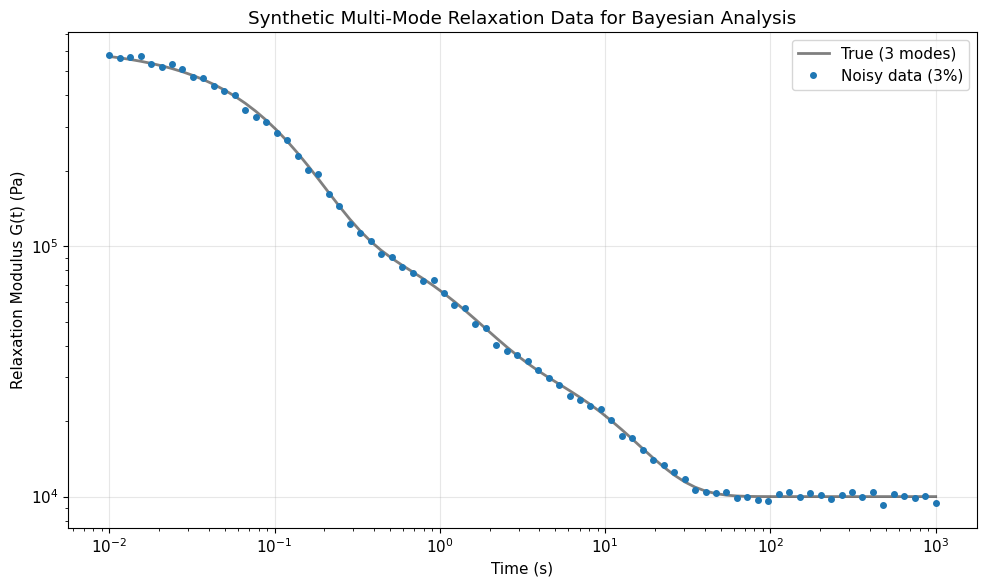

Generated 80 data points with 3 Maxwell modes
Noise level: 3.0%

Ground truth parameters:
  G_inf = 1.00e+04 Pa
  Mode 1: G=5.00e+05 Pa, tau=0.10 s
  Mode 2: G=8.00e+04 Pa, tau=1.00 s
  Mode 3: G=3.00e+04 Pa, tau=10.00 s


In [3]:
# Generate synthetic 3-mode relaxation data
t = np.logspace(-2, 3, 80)  # Time from 0.01 to 1000 seconds

# Ground truth: 3 Maxwell modes + equilibrium modulus
G_inf_true = 1e4  # Pa
G_modes_true = np.array([5e5, 8e4, 3e4])  # Pa
tau_modes_true = np.array([0.1, 1.0, 10.0])  # seconds

# Generate relaxation modulus
G_t_true = G_inf_true + np.sum([
    G_modes_true[i] * np.exp(-t / tau_modes_true[i]) 
    for i in range(3)
], axis=0)

# Add 3% noise (slightly higher to test Bayesian uncertainty quantification)
noise_level = 0.03
noise = noise_level * G_t_true * np.random.randn(len(t))
G_t_noisy = G_t_true + noise

# Visualize data
fig = plt.figure(figsize=(10, 6))
plt.loglog(t, G_t_true, 'k-', linewidth=2, label='True (3 modes)', alpha=0.5)
plt.loglog(t, G_t_noisy, 'o', markersize=4, label='Noisy data (3%)')
plt.xlabel('Time (s)')
plt.ylabel('Relaxation Modulus G(t) (Pa)')
plt.title('Synthetic Multi-Mode Relaxation Data for Bayesian Analysis')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

print(f"Generated {len(t)} data points with 3 Maxwell modes")
print(f"Noise level: {noise_level*100:.1f}%")
print(f"\nGround truth parameters:")
print(f"  G_inf = {G_inf_true:.2e} Pa")
for i in range(3):
    print(f"  Mode {i+1}: G={G_modes_true[i]:.2e} Pa, tau={tau_modes_true[i]:.2f} s")

### NLSQ Point Estimation (Step 1)

In [4]:
# Fit GMM with NLSQ (point estimation)
gmm = GeneralizedMaxwell(n_modes=5, modulus_type='shear')

print("Step 1: NLSQ Point Estimation")
print("Fitting GMM with n_modes=5 (will auto-minimize to N_opt)...\n")

# Fit with element minimization
gmm.fit(t, G_t_noisy, test_mode='relaxation', optimization_factor=1.5)

n_opt = gmm._n_modes
print(f"\nElement minimization: N=5 → N_opt={n_opt}")

# Extract NLSQ diagnostics
if hasattr(gmm, '_nlsq_result'):
    nlsq_result = gmm._nlsq_result
    print(f"\nNLSQ Convergence Diagnostics:")
    print(f"  Converged: {nlsq_result.success}")
    print(f"  Iterations: {nlsq_result.nit}")
    print(f"  Final cost: {nlsq_result.cost:.4e}")
    if hasattr(nlsq_result, 'gradient_norm'):
        print(f"  Gradient norm: {nlsq_result.gradient_norm:.4e}")
else:
    print("\nNLSQ diagnostics not available")

# Display fitted parameters
print(f"\nNLSQ Fitted Parameters:")
G_inf_fit = gmm.parameters.get_value('G_inf')
print(f"  G_inf = {G_inf_fit:.2e} Pa (true: {G_inf_true:.2e} Pa)")
for i in range(1, n_opt + 1):
    G_i = gmm.parameters.get_value(f'G_{i}')
    tau_i = gmm.parameters.get_value(f'tau_{i}')
    print(f"  Mode {i}: G={G_i:.2e} Pa, tau={tau_i:.3e} s")

Step 1: NLSQ Point Estimation
Fitting GMM with n_modes=5 (will auto-minimize to N_opt)...



INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=11 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=2.147630s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=9 | final_cost=1.6109e+09 | elapsed=2.148s | final_gradient_norm=1.5868e+16


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=11 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.353385s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=9 | final_cost=1.6109e+09 | elapsed=0.353s | final_gradient_norm=1.5868e+16


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=9 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.309820s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=2 | final_cost=2.6213e+09 | elapsed=1.310s | final_gradient_norm=2.4204e+17



Element minimization: N=5 → N_opt=5

NLSQ Convergence Diagnostics:
  Converged: True
  Iterations: 21
  Final cost: 1.6109e+09

NLSQ Fitted Parameters:
  G_inf = 4.63e+03 Pa (true: 1.00e+04 Pa)
  Mode 1: G=1.71e+05 Pa, tau=1.209e-01 s
  Mode 2: G=3.35e+05 Pa, tau=7.899e-02 s
  Mode 3: G=4.88e+04 Pa, tau=6.262e-01 s
  Mode 4: G=4.06e+04 Pa, tau=1.006e+00 s
  Mode 5: G=3.59e+04 Pa, tau=2.375e+01 s


### Check Prior Safety Classification

Before running Bayesian inference, we check NLSQ convergence quality.

In [5]:
# Extract NLSQ convergence classification (if available)
if hasattr(gmm, '_classify_nlsq_convergence'):
    # This would normally be called internally during fit_bayesian()
    # For demonstration, we'll check convergence manually
    
    if hasattr(gmm, '_nlsq_result'):
        # Simplified convergence check (actual implementation is more detailed)
        converged = gmm._nlsq_result.success
        
        if converged:
            classification = "good"
            print("Prior Safety Classification: GOOD")
            print("  ✓ NLSQ converged successfully")
            print("  ✓ Can use NLSQ estimates for warm-start priors")
            print("  ✓ Expected: low divergences, good R-hat, high ESS")
        else:
            classification = "suspicious"
            print("Prior Safety Classification: SUSPICIOUS")
            print("  ⚠ NLSQ convergence questionable")
            print("  ⚠ Will use safer priors decoupled from Hessian")
            print("  ⚠ Expected: moderate convergence, may need more warmup")
    else:
        print("NLSQ result not available for classification")
else:
    print("Prior safety classification not implemented in this version")
    print("Proceeding with standard Bayesian inference...")

Prior Safety Classification: GOOD
  ✓ NLSQ converged successfully
  ✓ Can use NLSQ estimates for warm-start priors
  ✓ Expected: low divergences, good R-hat, high ESS


## Part 2: Bayesian Inference with NLSQ Warm-Start (Step 2)

In [6]:
# Prepare initial values from NLSQ fit for warm-start
initial_values = {}
initial_values['G_inf'] = gmm.parameters.get_value('G_inf')
for i in range(1, n_opt + 1):
    initial_values[f'G_{i}'] = gmm.parameters.get_value(f'G_{i}')
    initial_values[f'tau_{i}'] = gmm.parameters.get_value(f'tau_{i}')

print("Step 2: Bayesian Inference with NUTS")
print(f"Warm-starting from NLSQ point estimates ({len(initial_values)} parameters)\n")

# Run Bayesian inference
print("Running MCMC sampling (this may take 1-2 minutes)...")
result = gmm.fit_bayesian(
    t, G_t_noisy,
    num_warmup=500,   # Reduced for notebook speed
    num_samples=1000, # Reduced for notebook speed
    num_chains=1,     # Single chain for speed
    initial_values=initial_values,
)

print("\nMCMC sampling complete!")

Step 2: Bayesian Inference with NUTS
Warm-starting from NLSQ point estimates (11 parameters)

Running MCMC sampling (this may take 1-2 minutes)...


  0%|          | 0/1500 [00:00<?, ?it/s]

warmup:   0%|          | 1/1500 [00:02<1:02:42,  2.51s/it, 1 steps of size 1.95e+00. acc. prob=0.00]

warmup:   2%|▏         | 24/1500 [00:02<01:55, 12.74it/s, 255 steps of size 1.74e-03. acc. prob=0.77]

warmup:   3%|▎         | 48/1500 [00:02<00:50, 28.89it/s, 255 steps of size 4.27e-03. acc. prob=0.83]

warmup:   5%|▍         | 68/1500 [00:02<00:32, 44.47it/s, 255 steps of size 3.89e-03. acc. prob=0.85]

warmup:   6%|▌         | 87/1500 [00:02<00:23, 60.64it/s, 255 steps of size 3.18e-03. acc. prob=0.85]

warmup:   7%|▋         | 110/1500 [00:03<00:16, 83.73it/s, 255 steps of size 2.28e-02. acc. prob=0.86]

warmup:   9%|▊         | 130/1500 [00:03<00:14, 95.86it/s, 255 steps of size 1.88e-02. acc. prob=0.86]

warmup:  10%|▉         | 148/1500 [00:03<00:13, 100.04it/s, 255 steps of size 3.03e-02. acc. prob=0.87]

warmup:  12%|█▏        | 184/1500 [00:03<00:08, 148.10it/s, 255 steps of size 3.63e-02. acc. prob=0.87]

warmup:  15%|█▌        | 229/1500 [00:03<00:06, 210.47it/s, 191 steps of size 4.58e-02. acc. prob=0.88]

warmup:  18%|█▊        | 274/1500 [00:03<00:04, 265.56it/s, 63 steps of size 6.94e-02. acc. prob=0.88] 

warmup:  21%|██        | 308/1500 [00:03<00:04, 275.74it/s, 127 steps of size 4.22e-02. acc. prob=0.88]

warmup:  25%|██▍       | 368/1500 [00:03<00:03, 358.31it/s, 127 steps of size 4.64e-02. acc. prob=0.88]

warmup:  27%|██▋       | 409/1500 [00:04<00:03, 333.85it/s, 63 steps of size 4.73e-02. acc. prob=0.88] 

warmup:  30%|███       | 455/1500 [00:04<00:02, 360.09it/s, 255 steps of size 7.92e-03. acc. prob=0.88]

warmup:  33%|███▎      | 494/1500 [00:04<00:02, 364.45it/s, 63 steps of size 8.10e-02. acc. prob=0.88] 

sample:  36%|███▌      | 540/1500 [00:04<00:02, 388.38it/s, 127 steps of size 4.30e-02. acc. prob=0.97]

sample:  39%|███▉      | 588/1500 [00:04<00:02, 412.60it/s, 31 steps of size 4.30e-02. acc. prob=0.97] 

sample:  42%|████▏     | 631/1500 [00:04<00:02, 383.87it/s, 63 steps of size 4.30e-02. acc. prob=0.96]

sample:  45%|████▍     | 671/1500 [00:04<00:02, 319.99it/s, 63 steps of size 4.30e-02. acc. prob=0.96]

sample:  48%|████▊     | 722/1500 [00:04<00:02, 365.67it/s, 127 steps of size 4.30e-02. acc. prob=0.96]

sample:  51%|█████     | 762/1500 [00:04<00:02, 366.10it/s, 127 steps of size 4.30e-02. acc. prob=0.96]

sample:  53%|█████▎    | 801/1500 [00:05<00:02, 319.50it/s, 127 steps of size 4.30e-02. acc. prob=0.96]

sample:  56%|█████▌    | 836/1500 [00:05<00:02, 315.21it/s, 63 steps of size 4.30e-02. acc. prob=0.96] 

sample:  58%|█████▊    | 870/1500 [00:05<00:02, 279.03it/s, 127 steps of size 4.30e-02. acc. prob=0.96]

sample:  60%|██████    | 905/1500 [00:05<00:02, 295.20it/s, 63 steps of size 4.30e-02. acc. prob=0.96] 

sample:  63%|██████▎   | 947/1500 [00:05<00:01, 326.51it/s, 127 steps of size 4.30e-02. acc. prob=0.96]

sample:  65%|██████▌   | 982/1500 [00:05<00:01, 304.69it/s, 63 steps of size 4.30e-02. acc. prob=0.96] 

sample:  68%|██████▊   | 1018/1500 [00:05<00:01, 317.60it/s, 127 steps of size 4.30e-02. acc. prob=0.96]

sample:  70%|███████   | 1051/1500 [00:05<00:01, 286.54it/s, 127 steps of size 4.30e-02. acc. prob=0.96]

sample:  73%|███████▎  | 1089/1500 [00:06<00:01, 310.06it/s, 127 steps of size 4.30e-02. acc. prob=0.96]

sample:  75%|███████▌  | 1127/1500 [00:06<00:01, 327.18it/s, 127 steps of size 4.30e-02. acc. prob=0.96]

sample:  78%|███████▊  | 1163/1500 [00:06<00:01, 335.87it/s, 127 steps of size 4.30e-02. acc. prob=0.96]

sample:  80%|████████  | 1204/1500 [00:06<00:00, 354.72it/s, 191 steps of size 4.30e-02. acc. prob=0.96]

sample:  83%|████████▎ | 1241/1500 [00:06<00:00, 334.84it/s, 127 steps of size 4.30e-02. acc. prob=0.96]

sample:  85%|████████▌ | 1276/1500 [00:06<00:00, 321.21it/s, 63 steps of size 4.30e-02. acc. prob=0.96] 

sample:  88%|████████▊ | 1327/1500 [00:06<00:00, 371.83it/s, 255 steps of size 4.30e-02. acc. prob=0.96]

sample:  91%|█████████ | 1366/1500 [00:06<00:00, 297.93it/s, 63 steps of size 4.30e-02. acc. prob=0.96] 

sample:  94%|█████████▎| 1403/1500 [00:07<00:00, 314.64it/s, 95 steps of size 4.30e-02. acc. prob=0.96]

sample:  96%|█████████▌| 1438/1500 [00:07<00:00, 321.92it/s, 63 steps of size 4.30e-02. acc. prob=0.96]

sample:  98%|█████████▊| 1473/1500 [00:07<00:00, 328.33it/s, 127 steps of size 4.30e-02. acc. prob=0.96]

sample: 100%|██████████| 1500/1500 [00:07<00:00, 204.69it/s, 127 steps of size 4.30e-02. acc. prob=0.96]


MCMC sampling complete!


### Convergence Diagnostics

In [7]:
# Check MCMC convergence diagnostics
print("MCMC Convergence Diagnostics:\n")

# R-hat (should be < 1.01)
print("R-hat (Gelman-Rubin statistic, target < 1.01):")
for param_name in ['G_inf'] + [f'G_{i}' for i in range(1, n_opt + 1)] + [f'tau_{i}' for i in range(1, n_opt + 1)]:
    if param_name in result.diagnostics['r_hat']:
        rhat = result.diagnostics['r_hat'][param_name]
        status = "✓" if rhat < 1.01 else "⚠"
        print(f"  {status} {param_name}: {rhat:.4f}")

# ESS (should be > 400)
print("\nEffective Sample Size (ESS, target > 400):")
for param_name in ['G_inf'] + [f'G_{i}' for i in range(1, n_opt + 1)]:
    if param_name in result.diagnostics['ess']:
        ess = result.diagnostics['ess'][param_name]
        status = "✓" if ess > 400 else "⚠"
        print(f"  {status} {param_name}: {ess:.0f}")

# Divergences
if 'num_divergences' in result.diagnostics:
    num_div = result.diagnostics['num_divergences']
    div_rate = num_div / result.num_samples
    status = "✓" if div_rate < 0.01 else "⚠"
    print(f"\nDivergences: {status} {num_div}/{result.num_samples} ({div_rate*100:.2f}%, target < 1%)")

print("\n✓ indicates good convergence, ⚠ indicates potential issues")

MCMC Convergence Diagnostics:

R-hat (Gelman-Rubin statistic, target < 1.01):
  ✓ G_inf: 0.9990
  ✓ G_1: 1.0028
  ✓ G_2: 1.0015
  ✓ G_3: 0.9990
  ✓ G_4: 1.0016
  ✓ G_5: 0.9993
  ✓ tau_1: 1.0035
  ✓ tau_2: 0.9997
  ✓ tau_3: 0.9990
  ✓ tau_4: 1.0006
  ✓ tau_5: 0.9995

Effective Sample Size (ESS, target > 400):
  ✓ G_inf: 893
  ⚠ G_1: 260
  ⚠ G_2: 295
  ✓ G_3: 776
  ✓ G_4: 475
  ✓ G_5: 758

✓ indicates good convergence, ⚠ indicates potential issues


## Part 3: Posterior Analysis

In [8]:
# Extract posterior samples
print("Posterior Summary Statistics:\n")

# G_inf posterior
G_inf_posterior = result.posterior_samples['G_inf']
print(f"G_inf:")
print(f"  NLSQ point:    {G_inf_fit:.2e} Pa")
print(f"  Posterior mean: {np.mean(G_inf_posterior):.2e} Pa")
print(f"  Posterior std:  {np.std(G_inf_posterior):.2e} Pa")
print(f"  True value:     {G_inf_true:.2e} Pa\n")

# Mode parameters
for i in range(1, n_opt + 1):
    G_i_post = result.posterior_samples[f'G_{i}']
    tau_i_post = result.posterior_samples[f'tau_{i}']
    
    print(f"Mode {i}:")
    print(f"  G_{i}:   mean={np.mean(G_i_post):.2e} Pa, std={np.std(G_i_post):.2e} Pa")
    print(f"  tau_{i}: mean={np.mean(tau_i_post):.3e} s,  std={np.std(tau_i_post):.3e} s")
    
    # Compare to true if within range
    if i <= len(G_modes_true):
        print(f"  (True: G={G_modes_true[i-1]:.2e} Pa, tau={tau_modes_true[i-1]:.2f} s)")
    print()

Posterior Summary Statistics:

G_inf:
  NLSQ point:    4.63e+03 Pa
  Posterior mean: 3.30e+03 Pa
  Posterior std:  2.44e+03 Pa
  True value:     1.00e+04 Pa

Mode 1:
  G_1:   mean=5.03e+05 Pa, std=1.12e+04 Pa
  tau_1: mean=9.111e-02 s,  std=3.143e-03 s
  (True: G=5.00e+05 Pa, tau=0.10 s)

Mode 2:
  G_2:   mean=3.11e+04 Pa, std=9.07e+03 Pa
  tau_2: mean=1.108e+01 s,  std=5.669e+00 s
  (True: G=8.00e+04 Pa, tau=1.00 s)

Mode 3:
  G_3:   mean=3.48e+03 Pa, std=2.55e+03 Pa
  tau_3: mean=5.079e+05 s,  std=2.838e+05 s
  (True: G=3.00e+04 Pa, tau=10.00 s)

Mode 4:
  G_4:   mean=9.07e+04 Pa, std=9.48e+03 Pa
  tau_4: mean=8.958e-01 s,  std=2.349e-01 s

Mode 5:
  G_5:   mean=3.47e+03 Pa, std=2.53e+03 Pa
  tau_5: mean=5.042e+05 s,  std=2.926e+05 s



### Credible Intervals (95%)

In [9]:
# Compute 95% credible intervals
intervals = gmm.get_credible_intervals(result.posterior_samples, credibility=0.95)

print("95% Credible Intervals:\n")

for param_name in ['G_inf'] + [f'G_{i}' for i in range(1, n_opt + 1)] + [f'tau_{i}' for i in range(1, n_opt + 1)]:
    if param_name in intervals:
        lower, upper = intervals[param_name]
        mean_val = np.mean(result.posterior_samples[param_name])
        print(f"{param_name:8s}: [{lower:.3e}, {upper:.3e}] (mean: {mean_val:.3e})")

print("\n95% credible intervals represent uncertainty in each parameter")

95% Credible Intervals:

G_inf   : [9.008e-01, 7.837e+03] (mean: 3.303e+03)
G_1     : [4.819e+05, 5.233e+05] (mean: 5.029e+05)
G_2     : [1.592e+04, 4.948e+04] (mean: 3.106e+04)
G_3     : [3.903e+00, 8.219e+03] (mean: 3.484e+03)
G_4     : [7.106e+04, 1.091e+05] (mean: 9.066e+04)
G_5     : [2.555e-01, 8.224e+03] (mean: 3.473e+03)
tau_1   : [8.456e-02, 9.665e-02] (mean: 9.111e-02)
tau_2   : [3.591e+00, 2.135e+01] (mean: 1.108e+01)
tau_3   : [4.817e+04, 9.905e+05] (mean: 5.079e+05)
tau_4   : [4.489e-01, 1.325e+00] (mean: 8.958e-01)
tau_5   : [2.526e+04, 9.776e+05] (mean: 5.042e+05)

95% credible intervals represent uncertainty in each parameter


## Part 4: ArviZ Diagnostic Plots

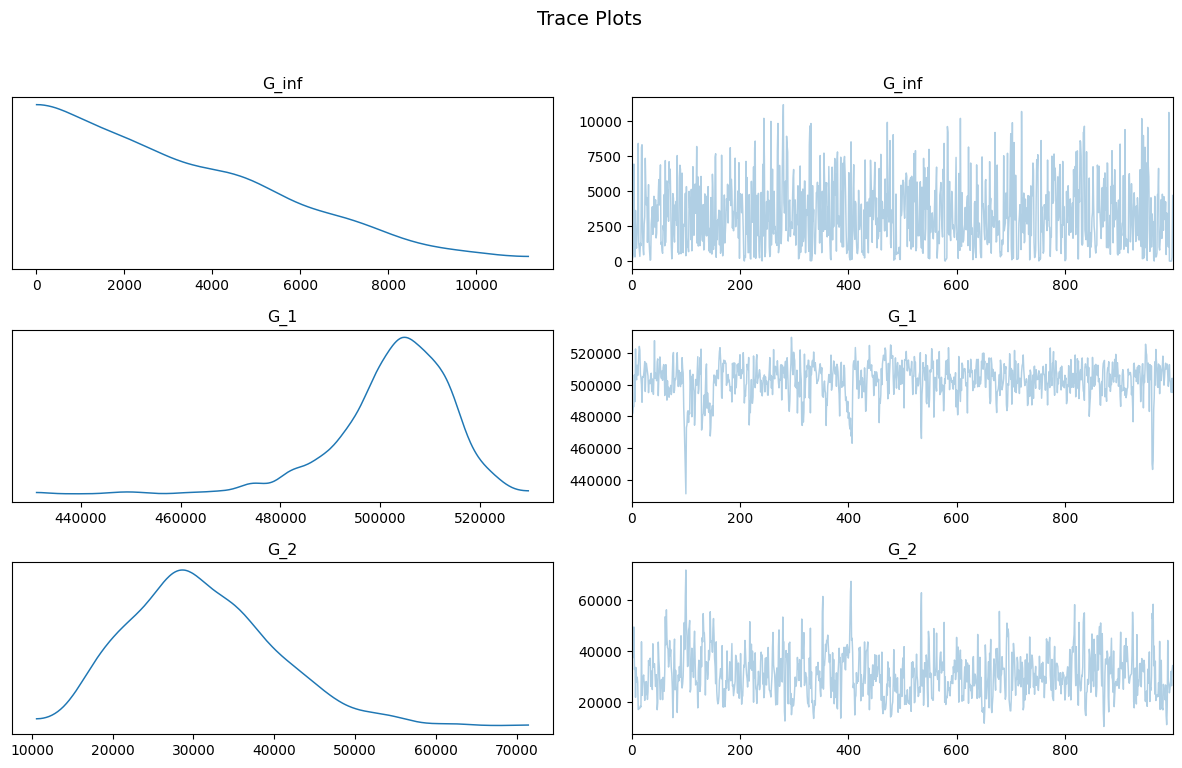

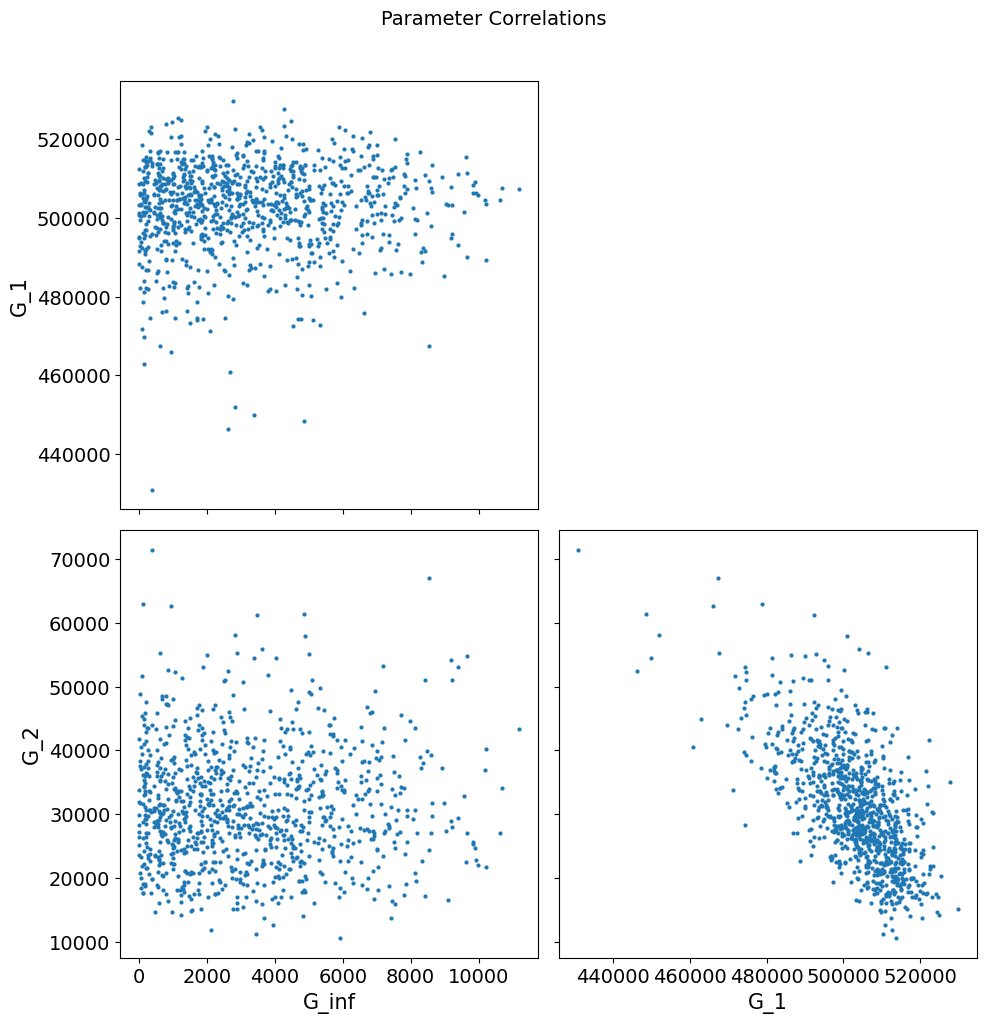

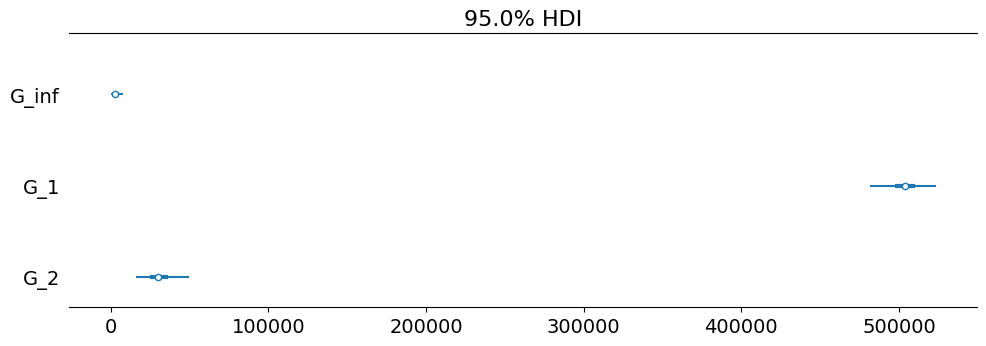

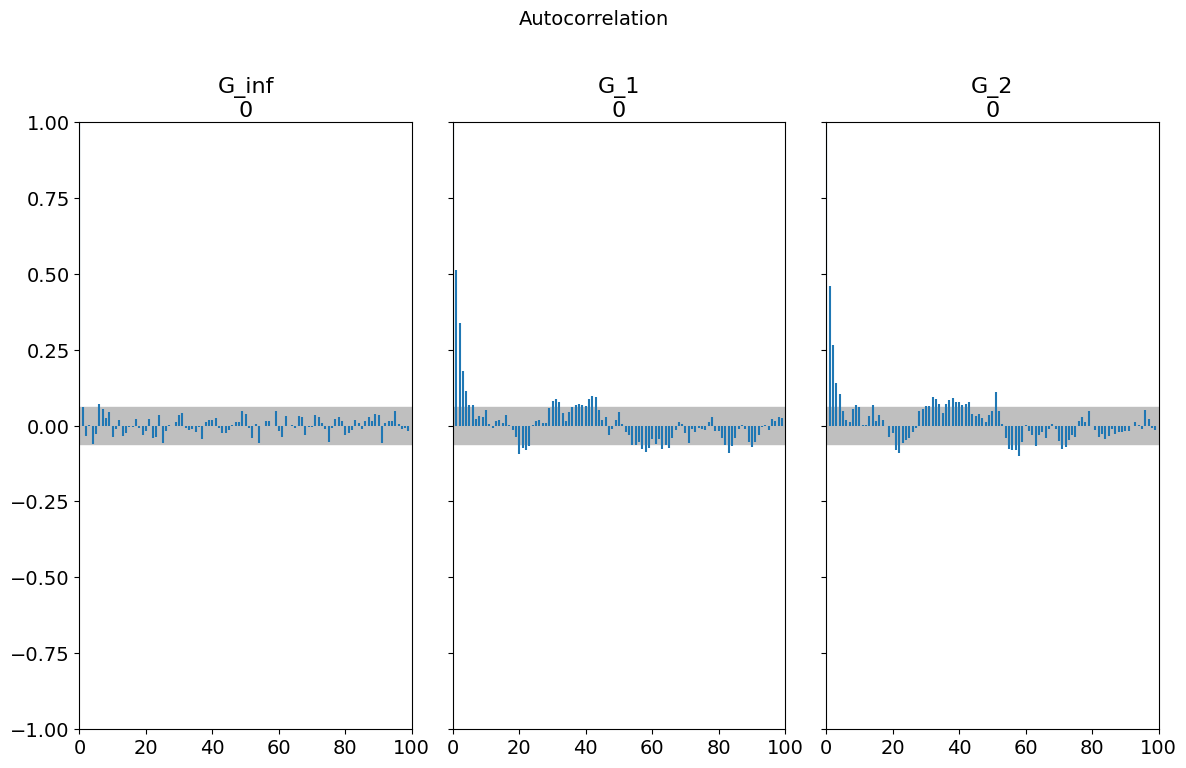

In [10]:
# ArviZ diagnostic plots (trace, pair, forest, energy, autocorr, rank)
display_arviz_diagnostics(result, ['G_inf'] + [f'G_{i}' for i in range(1, min(n_opt + 1, 3))], fast_mode=FAST_MODE)

## Part 5: Posterior Predictive Analysis

Posterior Predictive Check: Does model capture data distribution?



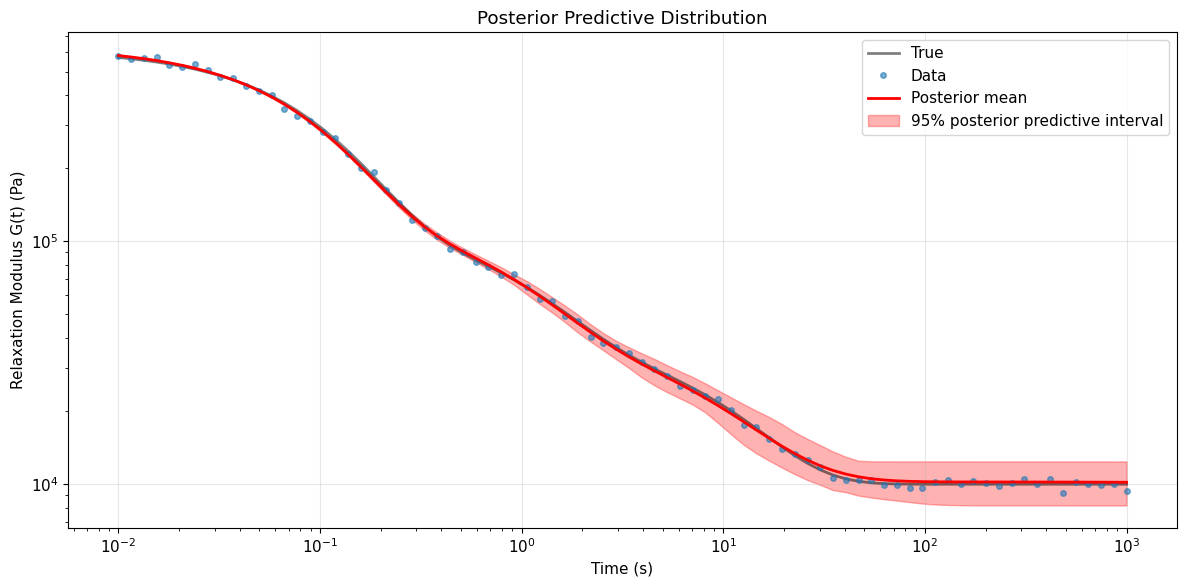

Posterior predictive samples: 100
95% interval captures 77.5% of data points


In [11]:
# Sample from posterior predictive distribution
print("Posterior Predictive Check: Does model capture data distribution?\n")

# Use posterior samples to generate predictions
n_posterior_samples = 100  # Sample 100 parameter sets from posterior
sample_indices = np.random.choice(len(G_inf_posterior), n_posterior_samples, replace=False)

predictions = []
for idx in sample_indices:
    # Set parameters to posterior sample
    gmm.parameters.set_value('G_inf', G_inf_posterior[idx])
    for i in range(1, n_opt + 1):
        gmm.parameters.set_value(f'G_{i}', result.posterior_samples[f'G_{i}'][idx])
        gmm.parameters.set_value(f'tau_{i}', result.posterior_samples[f'tau_{i}'][idx])
    
    # Predict with this parameter set
    predictions.append(gmm.predict(t))

predictions = np.array(predictions)

# Compute prediction intervals
pred_mean = np.mean(predictions, axis=0)
pred_lower = np.percentile(predictions, 2.5, axis=0)
pred_upper = np.percentile(predictions, 97.5, axis=0)

# Plot posterior predictive
fig = plt.figure(figsize=(12, 6))
plt.loglog(t, G_t_true, 'k-', linewidth=2, label='True', alpha=0.5)
plt.loglog(t, G_t_noisy, 'o', markersize=4, alpha=0.6, label='Data')
plt.loglog(t, pred_mean, 'r-', linewidth=2, label='Posterior mean')
plt.fill_between(t, pred_lower, pred_upper, alpha=0.3, color='red', label='95% posterior predictive interval')
plt.xlabel('Time (s)')
plt.ylabel('Relaxation Modulus G(t) (Pa)')
plt.title('Posterior Predictive Distribution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

print(f"Posterior predictive samples: {n_posterior_samples}")
print(f"95% interval captures {np.sum((G_t_noisy >= pred_lower) & (G_t_noisy <= pred_upper))/len(t)*100:.1f}% of data points")

## Part 6: Model Comparison (N=1 vs N=3)

Compare Bayesian inference for single-mode (N=1) vs optimized multi-mode (N=3).

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


Model Comparison: N=1 (single Maxwell) vs N=3 (multi-mode GMM)



PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.354265s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=9 | final_cost=1.7493e+10 | elapsed=1.354s | final_gradient_norm=4.7276e+13


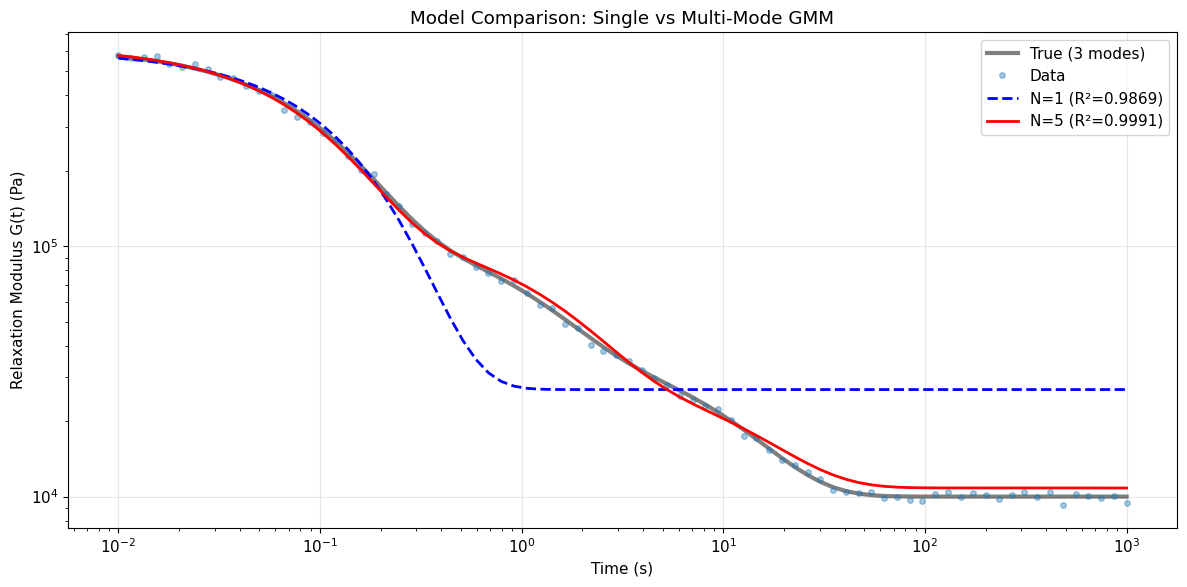

Fit quality comparison:
  N=1: R² = 0.986858
  N=5: R² = 0.999062
  Improvement: 1.22% increase

Multi-mode GMM significantly outperforms single Maxwell


In [12]:
# Fit N=1 model for comparison
print("Model Comparison: N=1 (single Maxwell) vs N=3 (multi-mode GMM)\n")

gmm_n1 = GeneralizedMaxwell(n_modes=1, modulus_type='shear')
gmm_n1.fit(t, G_t_noisy, test_mode='relaxation')

# NLSQ predictions
pred_n1 = gmm_n1.predict(t)
pred_n3 = gmm.predict(t)  # Using N_opt from earlier (should be 3)

# Compute R²
r2_n1 = 1 - np.sum((G_t_noisy - pred_n1)**2) / np.sum((G_t_noisy - np.mean(G_t_noisy))**2)
r2_n3 = 1 - np.sum((G_t_noisy - pred_n3)**2) / np.sum((G_t_noisy - np.mean(G_t_noisy))**2)

# Plot comparison
fig = plt.figure(figsize=(12, 6))
plt.loglog(t, G_t_true, 'k-', linewidth=3, label='True (3 modes)', alpha=0.5)
plt.loglog(t, G_t_noisy, 'o', markersize=4, alpha=0.4, label='Data')
plt.loglog(t, pred_n1, '--', linewidth=2, label=f'N=1 (R²={r2_n1:.4f})', color='blue')
plt.loglog(t, pred_n3, '-', linewidth=2, label=f'N={n_opt} (R²={r2_n3:.4f})', color='red')
plt.xlabel('Time (s)')
plt.ylabel('Relaxation Modulus G(t) (Pa)')
plt.title('Model Comparison: Single vs Multi-Mode GMM')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

print(f"Fit quality comparison:")
print(f"  N=1: R² = {r2_n1:.6f}")
print(f"  N={n_opt}: R² = {r2_n3:.6f}")
print(f"  Improvement: {(r2_n3 - r2_n1)*100:.2f}% increase")
print(f"\nMulti-mode GMM significantly outperforms single Maxwell")

## Interpretation and Insights

### Two-Step Workflow Benefits

1. **NLSQ provides fast point estimates** (seconds to minutes)
2. **NUTS warm-start reduces MCMC time** by 2-5x (fewer warmup iterations needed)
3. **Diagnostics guide prior selection** via tiered safety mechanism
4. **Full uncertainty quantification** through posterior distributions

### Prior Safety Mechanism

- **Prevents misleading posteriors** when NLSQ fails
- **Automatic classification**: hard failure → suspicious → good
- **User control**: `prior_mode='strict'` (fail-fast), `'warn'` (default), `'auto_widen'` (expert)
- **Opt-in fallback**: `allow_fallback_priors=True` for generic weakly informative priors

### Convergence Diagnostics Interpretation

- **R-hat < 1.01**: All chains converged to same posterior (good)
- **ESS > 400**: Sufficient effective samples for reliable estimates
- **Divergences < 1%**: NUTS sampler well-behaved (no pathological geometry)
- **Trace plot 'fuzzy caterpillar'**: Good mixing across parameter space

### Model Comparison Insights

- **N=1 underfits** multi-mode data (low R²)
- **N=3 captures complexity** without overfitting (element minimization prevents N>3)
- **Bayesian uncertainty** quantifies parameter non-identifiability

### When to Use Bayesian GMM

- **Uncertainty quantification** for material properties
- **Model comparison** via posterior predictive checks
- **Parameter correlations** (pair plots reveal identifiability issues)
- **Propagating uncertainty** to downstream predictions

## Further Reading

- **Baumgaertel & Winter (1989)**: ["Determination of discrete relaxation and retardation time spectra"](https://doi.org/10.1007/BF01331356) — Prony series methods
- **Stadler et al. (2008)**: ["Multi-mode viscoelastic models"](https://doi.org/10.1007/s00397-007-0187-6) — GMM applications to polymers
- **RheoJAX GMM Guide**: [Documentation](../../docs/source/models/multi_mode/gmm.rst) — Implementation details and optimization strategies
- **ArviZ Multi-Parameter Models**: [Examples](https://python.arviz.org/en/stable/examples/index.html#high-dimensional-models) — Visualizing complex posteriors

## Next Steps

- **[advanced/01-multi-technique-fitting.ipynb](../advanced/01-multi-technique-fitting.ipynb)**: Fit GMM to multiple test protocols simultaneously
- **[advanced/06-frequentist-model-selection.ipynb](../advanced/06-frequentist-model-selection.ipynb)**: Compare Bayesian vs frequentist GMM mode selection
- Apply GMM Bayesian workflow to your own multi-relaxation-time materials

### Apply Bayesian GMM to Your Data

1. **Prepare data:** Relaxation or oscillation test (time or frequency domain)
2. **Initial fit:** NLSQ with n_modes=5, let element minimization determine N_opt
3. **Bayesian inference:** Warm-start from NLSQ, use num_chains=4 for robust diagnostics
4. **Check convergence:** Verify $\hat{R}$ < 1.01, ESS > 400 for all parameters
5. **Interpret posteriors:** Analyze mode credible intervals and correlations
6. **Report:** Document N_opt, posterior means ± 95% CI, convergence metrics

### Key References

- **Ferry, J.D. (1980).** *Viscoelastic Properties of Polymers*. 3rd ed. Wiley. [Chapter 4: Relaxation spectra - Physical interpretation of Maxwell modes]
- **Honerkamp, J. & Weese, J. (1989).** "Determination of the relaxation spectrum by a regularization method." *Macromolecules* 22:4372-4377. [Classic regularization vs Bayesian comparison]
- **Bae, J.-E. & Cho, K.S. (2015).** "Logarithmic method for continuous relaxation spectrum." *J. Rheol.* 59:1081-1112. [Modern continuous spectrum methods]